# ARIMA

The most widespread traditional univariate time series model is the ARIMA model. Several ARIMA models will be trained and compared with the results obtained when evaluating the baseline. 

For the **evaluation** it is worth noting the following:
- The fold that will be most valued among models is the one corresponding to 2019, as there is enough history, it is similar to the previous year, so good results are expected in any model. 
- 2018 will not be considered for comparison because there is not enough history for the model to provide good results (as will be seen below) and also the data from previous years are not very similar. 
- 2020 cannot be considered either because they have been artificially adulterated (see EDA).
- However both 2018 and 2020 will be considered when evaluating just for the sake of curiosity and to detect potential unexpected behaviour.

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sktime.split import ExpandingWindowSplitter
from sktime.forecasting.model_evaluation import evaluate
from sktime.performance_metrics.forecasting import (
    MeanAbsoluteError,
    MeanSquaredError,
    MeanAbsolutePercentageError,
)

from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.forecasting.arima import ARIMA, AutoARIMA

# filter warnings
import warnings
warnings.filterwarnings("ignore")

In [45]:
# Read train data
ts = pd.read_csv(
    "../data/processed_train.csv",  # data path
    index_col=[0],  # index column
    parse_dates=[0],  # parse date column
)

# Get training data
train_ts = ts.dropna()

# Assert time series dates consistency by checking all dates are monthly and recorded properly (this includes missing dates if any)
train_ts = train_ts.asfreq("MS").fillna(
    0
)  # if there are missing dates, they will be filled with 0

In [46]:
y = train_ts.copy()  # copy to avoid any changes to original data
y.index = pd.PeriodIndex(y.index, freq="M")  # required frequency from sktime

# ARIMA

- Two experiments will be carried out here. 
1. First, the simplest option: the AutoARIMA to determine the orders of the model. 
2. As this kind of models do not usually give good results (at least in my experience), an ARIMA will be fitted with the knowledge extracted from the EDA. 

## AutoARIMA

,test_MeanSquaredError,test_MeanAbsoluteError,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff
0,0.619957,0.535805,0.222601,1.388954,0.018233,37,2018-01
1,0.483412,0.403012,0.154666,7.977076,0.009211,49,2019-01
2,0.298583,0.227731,0.085965,6.899526,0.011153,61,2020-01


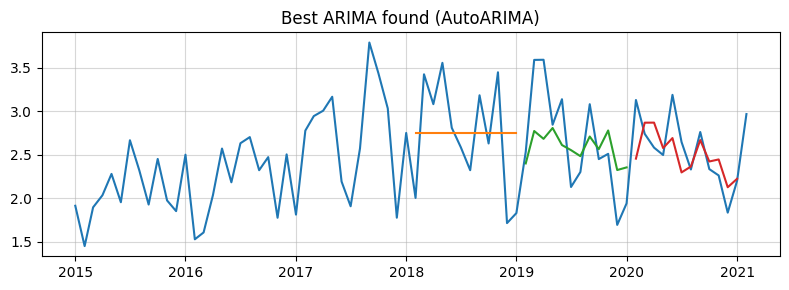

In [47]:
# Define time series cross validation)
cv = ExpandingWindowSplitter(initial_window=37, step_length=12, fh=np.arange(1, 13))

forecaster = TransformedTargetForecaster(
    [
        # ("log", LogTransformer()),
        (
            "forecast",
            AutoARIMA(
                sp=12,
                start_p=0,
                d=1,
                start_q=0,
                max_p=5,
                max_d=2,
                max_q=5,
                start_P=0,
                D=None,
                start_Q=0,
                max_P=2,
                max_D=1,
                max_Q=2,
                max_order=5,
                seasonal=True,
            ),
        )
    ]
)


results = evaluate(
    forecaster=forecaster,
    y=y,
    cv=cv,
    scoring=[
        MeanSquaredError(square_root=True),
        MeanAbsoluteError(),
        MeanAbsolutePercentageError(),
    ],
)

display(results)

# Plot forecasts for each split of cv
fig = plt.figure(figsize=(8, 3))
plt.plot(train_ts)
for train, test in cv.split(y):
    model = forecaster.fit(y.iloc[train])
    y_pred_1 = model.predict(fh=y.iloc[test].index)
    plt.plot(train_ts.iloc[test].index, y_pred_1)
plt.grid(alpha=0.5)
plt.title("Best ARIMA found (AutoARIMA)")
plt.tight_layout()
plt.show()

- AutoARIMA fails in beating the baseline on the important fold of 2019 (both using a log transform and using raw data). 
- The constant forecast for 2018 shows that the mean is well captured, but the model is not able to fully capture other patterns. Perhaps due to the short length of the series.

## ARIMA

Based on EDA:
- The series is not stationary, so a difference of order 1 will be applied to stabilize mean together with a log transform to stabilize variance. 
- A seasonal pattern of period 12 was present on 2017, 2018 and 2019, so a seasonal difference of order 1 will be applied.
- After studying different orders and transforms (boxcox, sqrt and log) the following is the ARIMA found. 

,test_MeanSquaredError,test_MeanAbsoluteError,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff
0,1.174655,0.958420,0.397385,0.304826,0.029143,37,2018-01
1,0.415477,0.323653,0.121826,0.339348,0.029449,49,2019-01
2,0.455080,0.368440,0.142906,0.323295,0.016517,61,2020-01


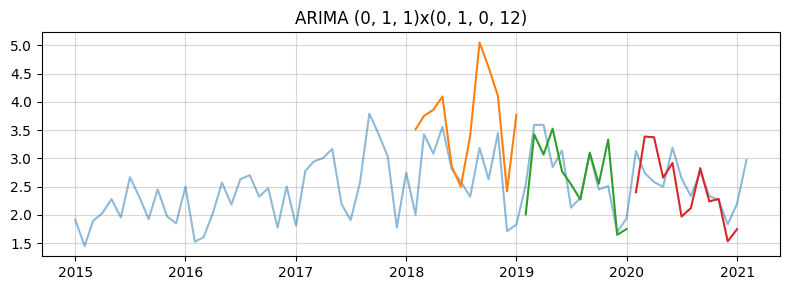

In [48]:
# Define time series cross validation)
from sktime.transformations.series.boxcox import LogTransformer

forecaster = TransformedTargetForecaster(
    [
        ("log", LogTransformer()),
        (
            "forecast",
            ARIMA(order=(0, 1, 1), seasonal_order=(0, 1, 0, 12)),
        )
    ]
)


results = evaluate(
    forecaster=forecaster,
    y=y,
    cv=cv,
    scoring=[
        MeanSquaredError(square_root=True),
        MeanAbsoluteError(),
        MeanAbsolutePercentageError(),
    ],
)

display(results)

# Plot forecasts for each split of cv
fig = plt.figure(figsize=(8, 3))
plt.plot(train_ts, alpha=0.5)
for train, test in cv.split(y):
    model = forecaster.fit(y.iloc[train])
    y_pred_1 = model.predict(fh=y.iloc[test].index)
    plt.plot(train_ts.iloc[test].index, y_pred_1)
plt.grid(alpha=0.5)
plt.title("ARIMA (0, 1, 1)x(0, 1, 0, 12)")
plt.tight_layout()
plt.show()

- The ARIMA model found outperforms the baseline results set for the 2019 layer (also for 2020). 

### Residuals Study

In [49]:
import statsmodels

# Manual transform 
log_y = np.log(y)

# Fit ARIMA until 2019-01
model = statsmodels.tsa.arima.model.ARIMA(log_y.iloc[:49], order=(0, 1, 1), seasonal_order=(0, 1, 0, 12)).fit()
y_pred = model.predict(start=49, end=49+12-1, typ='levels')

# Study results
print(model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                   49
Model:             ARIMA(0, 1, 1)x(0, 1, [], 12)   Log Likelihood                  -6.146
Date:                           Wed, 17 Apr 2024   AIC                             16.292
Time:                                   23:39:47   BIC                             19.459
Sample:                               01-31-2015   HQIC                            17.398
                                    - 01-31-2019                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9320      0.133     -7.015      0.000      -1.192      -0.672
sigma2         0.0779      0.024      3.279

**Interpretation of results**
- Ljung-Box test at lag 1 has a p-value of 0.93>0.05, indicating the residuals are white noise. 
- The p value of Heteroskedasticity test is 0.21>0.05, implying the residuals are not heteroskedastic.
- Jarque-Bera test has a p-value of 0.73>0.05, indicating the residuals are normally distributed.

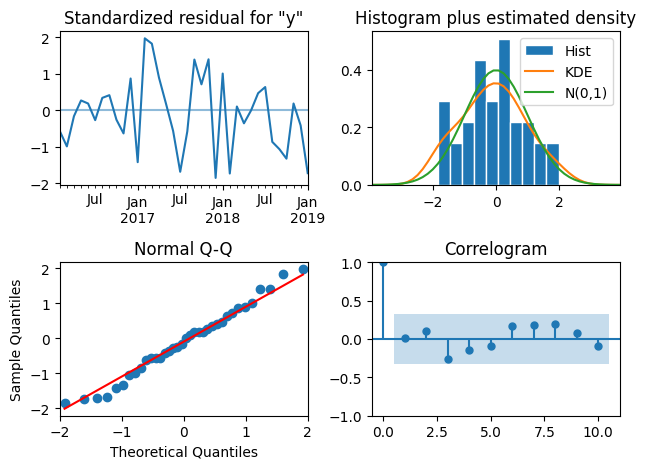

In [50]:
model.plot_diagnostics()
plt.tight_layout()
plt.show()

1. Standarized residuals have zero mean and constant variance. 
2. The histogram and density shows resemblance to a normal distribution.
3. Q-Q plot shows values aligned to the line, indicating normality.
4. The correlogram help in identifying the residuals randomness. The standard errors for confidence intervals are determined under the hypothesis that the residuals are white noise. Since they are close to zero and none exceed the confidence intervals, the residuals are white noise.

In [59]:
# Read evaluation file and merge with arima ones
eval_df = pd.read_csv(
    "../data/evaluation.csv",  # data path
    index_col=[0],  # index column
    parse_dates=[0],  # parse date column
)

results['model'] = 'arima'

# join with evaluation file on cutoff with concat
eval_df = pd.concat([results, eval_df], axis=0).sort_values(by=['test_MeanSquaredError'], ascending=True)

# Save evaluation file
eval_df.to_csv("../data/evaluation.csv")

eval_df

,test_MeanSquaredError,test_MeanAbsoluteError,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff,model
1,0.415477,0.323653,0.121826,0.339348,0.029449,49,2019-01,arima
1,0.441073,0.340174,0.127364,0.002210,0.102121,49,2019-01,baseline_naive_last
2,0.455080,0.368440,0.142906,0.323295,0.016517,61,2020-01,arima
2,0.479795,0.374270,0.143973,0.003071,0.026912,61,2020-01,baseline_naive_last
0,0.573653,0.507329,0.201105,0.002970,0.034698,37,2018-01,baseline_naive_last
0,1.174655,0.958420,0.397385,0.304826,0.029143,37,2018-01,arima
